## Data Exploration

In [152]:
#importing necessary imports

In [153]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from surprise.dataset 
from IPython.core.display import HTML

%matplotlib inline

SyntaxError: invalid syntax (<ipython-input-153-fca5cba4c816>, line 20)

## Exploring Review Data

In [ ]:
#reading in our data as a dataframe

In [ ]:
df = pd.read_json("Data/reviews_Beauty_5.json.gz",lines=True)

In [ ]:
df

In [ ]:
#checking for nulls

In [ ]:
df.isna().sum()

In [ ]:
#1386 reviewerNames left blank; we will not need reviewerName since utilizing reviewerID
#checking that all needed information is provided when reviewerName is NaN

In [ ]:
df[df['reviewerName'].isnull()]

In [ ]:
#checking that all reviewers have completed at least 5 reviews

In [ ]:
df.reviewerID.value_counts()

In [ ]:
#YAY! all reviewerIDs have value of at least 5, total of 22,363 reviewers

In [ ]:
#checking that all products have been reviewed at least 5 times

In [ ]:
df.asin.value_counts()

In [ ]:
#YAY! all products have at least 5 reviews, total of 12,101 different products

In [ ]:
#looking at ratings distribution

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['overall'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} reviews'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
#we see a majority of our ratings are 5s, which could impact our system

In [ ]:
#exploring number of ratings per product

In [ ]:
# Number of ratings per product
data = df.groupby('asin')['overall'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Product (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Product'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
#We see a majority of our projects have 10 or less ratings

In [ ]:
#exploring ratings distribution by user

In [ ]:
# Number of ratings per user
data = df.groupby('reviewerID')['overall'].count().clip(upper=50)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
#we see most users rated under 10 products

In [ ]:
lower_rating = df.overall.min()

In [ ]:
upper_rating = df.overall.max()

In [ ]:
#Confirming our review range is 1 to 5

In [154]:
print('Review range: {0} to {1}'.format(lower_rating, upper_rating))

Review range: 1 to 5


In [155]:
#Creating dataframe with appropriate columns to run through surprise

In [156]:
surprise_df = df[['reviewerID', 'asin', 'overall']]

In [157]:
surprise_df

,reviewerID,asin,overall
0,A1YJEY40YUW4SE,7806397051,1
1,A60XNB876KYML,7806397051,3
2,A3G6XNM240RMWA,7806397051,4
3,A1PQFP6SAJ6D80,7806397051,2
4,A38FVHZTNQ271F,7806397051,3
...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,5
198498,A1UQBFCERIP7VJ,B00LLPT4HI,5
198499,A35Q0RBM3YNQNF,B00LLPT4HI,5
198500,A3LGT6UZL99IW1,B00LLPT4HI,5


In [158]:
#Checking average rating user to see if there are users who rate everything 1 or 5

In [159]:
avg_rating_user = df.groupby("reviewerID")["overall","reviewerID"].mean().sort_values("overall")
avg_rating_user

<ipython-input-159-8752c1212ea2>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,overall
reviewerID,
A1W522Z24EPBJB,1.0
A2DPSPXFJ507C0,1.0
A1GQLVT0SWAWU,1.0
A1KLA02LZXAT46,1.0
A2MHHSACEJANSX,1.0
...,...
A15QGN6UXJVW9G,5.0
ANOJX4RAUJ9HL,5.0
A2RJT3IE2T6KXJ,5.0


In [160]:
low_rating_user = avg_rating_user[avg_rating_user["overall"]==1.0]
low_rating_user

,overall
reviewerID,
A1W522Z24EPBJB,1.0
A2DPSPXFJ507C0,1.0
A1GQLVT0SWAWU,1.0
A1KLA02LZXAT46,1.0
A2MHHSACEJANSX,1.0
A2RJTIE73NPN3C,1.0
ASWIC85F71H4J,1.0
A2TBE0N8JN6H4K,1.0
A1GPPMHYM6SMEW,1.0


In [161]:
#only 9 users have rated every product a 1

In [162]:
high_rating_user = avg_rating_user[avg_rating_user["overall"]==5.0]
high_rating_user

,overall
reviewerID,
A2FINIRQNXOTI,5.0
ATWS89FH6Y6S4,5.0
A16Q479PYT0G6N,5.0
A3OKW5VRXZG3OQ,5.0
A3O9Q3154FPZLL,5.0
...,...
A15QGN6UXJVW9G,5.0
ANOJX4RAUJ9HL,5.0
A2RJT3IE2T6KXJ,5.0


In [163]:
#2822 users have rated every product a 5

In [164]:
#we decide to keep these users in our final dataset but will not use them to test our model for recommendations

In [165]:
#elaborate on justification for keeping these reviews

## Exploring Meta Data

In [166]:
#Import our meta data 
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [167]:
meta_data_df = getDF("Data/meta_Beauty.json.gz")
meta_data_df

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,NaN
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided mirror: Each mirror is large enough to sh

In [168]:
meta_data_df.head(100)

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,NaN
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided mirror: Each mirror is large enough to sh

In [169]:
meta_data_df.isna().sum()

asin                0
description     24707
title             444
imUrl              88
salesRank        5188
categories          0
price           69274
related         51350
brand          131038
dtype: int64

In [170]:
#exploring NaN and deciding which data is helpful to return to our users for recommendations

In [171]:
meta_data_df.shape

(259204, 9)

In [172]:
69274/259205

0.2672556470747092

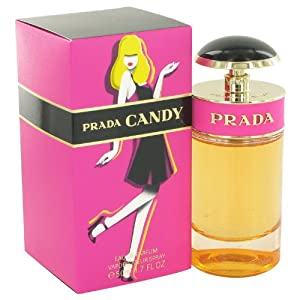

In [173]:
from IPython import display
display.Image(meta_data_df.loc[192]["imUrl"])
#display.Image(meta_data_df_cleaned.loc[259179]["imUrl"])

In [174]:
meta_data_df.price.describe()

count    189930.000000
mean         24.878165
std          33.431190
min           0.010000
25%           8.240000
50%          15.690000
75%          29.300000
max         999.990000
Name: price, dtype: float64

In [175]:
meta_data_df[meta_data_df['price'] == 999.99]

,asin,description,title,imUrl,salesRank,categories,price,related,brand
197364,B009PQIAL6,"This beautifully sculpted and gracefully designed bench will makes a luxurious statement in your salon. The unique design lends itself to many furniture arrangements. It gives you a lot of flexibility. Covered in black soft PVC vinyl over ample padding, it is very comfortable, durable, and made to last for many years to come. These powerful traditional-style box dryers provide an ample supply of heated air to spread heat quickly. While these dryers are not as warm as the classic style big head blow dryers, it has more power and gets the job done without the excessive overheating of a corded blow dryer. The powder-coated cabinet and hood ducts fit any decor, are easy to clean and always look sharp. The extra large smoke color hood and removable air filter provide convenience for the client and stylist. The cleverly designed wheel base provides the appearance of a built-in unit with the flexibility of portability when necessary.Package Includes:1qty -WC-18BLK&quot;Vernet&quot; Bench2qty -DE-11Box DryerDimensions:Bench-Height: 29&quot;Width: 68&quot;Depth: 31&quot;Arm to Arm: 60.5&quot;Dryer-Adjustable Height: 60&quot; to 49&quot;Box Height: 24&quot;Box Width: 12&quot;Box Depth: 7&quot;Dryer Head: 12&quot; (diameter)Adjustable Neck: 7&quot; to 15&quot;- All dimensions listed are approximations. Some assembly is required.",&quot;Vernet&quot; Black Dual Dryer Chair With Box Dryers,http://ecx.images-amazon.com/images/I/41ks5sFAZ7L._SY300_.jpg,{'Beauty': 582815},"[[Beauty, Tools & Accessories, Nail Tools, Nail Dryers]]",999.99,"{'also_viewed': ['B004O4N4OW', 'B009ZHVQYI', 'B0041HNVC2', 'B009PQHZ3A', 'B009PQI1U6', 'B0032CI2IU', 'B009PQ8BUG', 'B00AU7YGOY', 'B003TXUUKK', 'B003B4ILSK', 'B00563J3W2', 'B00563HCSE', 'B0041HPM1K', 'B004280N3U', 'B0085XY2MQ', 'B007ROD3O2', 'B006QH74TG', 'B007EG2MK4', 'B0087P00OG', 'B004UDWY7K', 'B0043VTK30', 'B004GGFQB2', 'B004GE9LXI']}",NaN


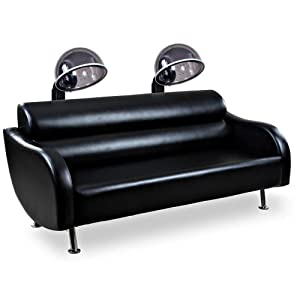

In [176]:
display.Image(meta_data_df.loc[197364]["imUrl"])

In [177]:
meta_data_df

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,NaN
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided mirror: Each mirror is large enough to sh

In [178]:
#renaming columns we plan to return to users for improved aesthetics

In [179]:
meta_data_df.rename(columns={'description':'Description', 'title': 'Product Name'}, inplace=True)

In [180]:
meta_data_df.rename(columns={'asin':'ASIN'}, inplace=True)

In [181]:
meta_data_df.head()

,ASIN,Description,Product Name,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,NaN
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided mirror: Each mirror is large enoug

In [182]:
meta_data_df.isna().sum()

ASIN                 0
Description      24707
Product Name       444
imUrl               88
salesRank         5188
categories           0
price            69274
related          51350
brand           131038
dtype: int64

In [183]:
#dropping brand due to large # of nulls

In [184]:
meta_data_df.drop(columns=['brand'], inplace=True)

## Setting Up Surprise

In [185]:
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, reader)

trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=23)

In [186]:
surprise_data

In [187]:
# How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  22359 

Number of items:  12101 



In [188]:
print('Type trainset :',type(trainset),'\n')
print('Type testset :',type(testset))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


## Dummy Model

In [ ]:
baseline = NormalPredictor()
baseline.fit(trainset)

In [ ]:
predictions = baseline.test(testset)

In [ ]:
baseline = accuracy.rmse(predictions)

In [ ]:
#baseline RMSE of 1.5002

## Baseline Models

In [ ]:
baseline2 = BaselineOnly()
baseline2.fit(trainset)

In [ ]:
predictions2 = baseline2.test(testset)

In [ ]:
baseline2 = accuracy.rmse(predictions2)

In [ ]:
#baseline RMSE of 1.089 utilizing BaselineOnly

In [ ]:
als_options = {'method': 'als',
               }
als_baseline = BaselineOnly(bsl_options=als_options)

In [ ]:
als_baseline.fit(trainset)

In [ ]:
predictions = als_baseline.test(testset)

In [ ]:
als_baseline = accuracy.rmse(predictions)

In [ ]:
sgd_options = {'method': 'sgd',
               }
sgd_baseline = BaselineOnly(bsl_options=sgd_options)

In [ ]:
sgd_baseline.fit(trainset)

In [ ]:
predictions = sgd_baseline.test(testset)

In [ ]:
sgd_baseline = accuracy.rmse(predictions)

In [ ]:
#our baseline model with sgd improved our RMSE to 1.0818

## Iterating Over All Algorithms to Assess Which Models to Further Explore

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

In [ ]:
#given our results, we will further explor SVDpp and SVD

## SVD Model Exploration

In [ ]:
#Running an SVD model with defaults on trainset

In [47]:
svd = SVD(random_state=42)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0889
1.0889451149217502


In [ ]:
#Checking to see estimated rating for 2 user/product combinations

In [ ]:
svd.predict('A1YJEY40YUW4SE', 'B00LLPT4HI')

In [ ]:
svd.predict('A2BLFCOPSMBOZ9', '7806397051')

In [ ]:
#Cross validate the model

In [ ]:
cv_svd_baseline = cross_validate(svd, surprise_data)

In [ ]:
cv_svd_baseline

### Attempt on new split

In [ ]:
#Hold out 10% of data for validation
#Create a new surpise data class
svd_data = Dataset.load_from_df(surprise_df, reader)
raw_ratings_svd = svd_data.raw_ratings
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings_svd))
A_raw_ratings_svd = raw_ratings_svd[:threshold]
B_raw_ratings_svd = raw_ratings_svd[threshold:]

In [ ]:
# svd_data is now the set A
svd_data.raw_ratings = A_raw_ratings_svd

In [ ]:
#Create a param grid for grid search
SVD_parm_grid = {'n_factors':[20,50,100,150],'n_epochs':[10,20,30],'biased':[True,False]}

In [ ]:
#Instantiate our grid search & fit to set A
#svd_grid_search = GridSearchCV(algo_class=SVD,param_grid=SVD_parm_grid,measures=['rmse'],cv=5)
#svd_grid_search.fit(svd_data)

In [ ]:
#best_svd_algo = svd_grid_search.best_estimator['rmse']

In [ ]:
#svd_grid_search.best_params

In [ ]:
#{'rmse': {'n_factors': 20, 'n_epochs': 20, 'biased': True}}

In [ ]:
# retrain on the whole set A
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

In [ ]:
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

In [ ]:
# Compute unbiased accuracy on B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # testset is now the set B
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

In [ ]:
svd2 = SVD(n_factors=20, n_epochs=20, biased=True, random_state=42)
svd2.fit(trainset)
predictions = svd2.test(testset)
print(accuracy.rmse(predictions))

### Attempt new grid search params with lower n_factors

In [ ]:
#SVD_parm_grid = {'n_factors':[2,5,10,20],'n_epochs':[10,20,30],'biased':[True,False]}

In [ ]:
#Instantiate our grid search & fit to set A
#svd_grid_search = GridSearchCV(algo_class=SVD,param_grid=SVD_parm_grid,measures=['rmse'],cv=5)
#svd_grid_search.fit(svd_data)

In [ ]:
#best_svd_algo = svd_grid_search.best_estimator['rmse']

In [ ]:
#svd_grid_search.best_params

In [ ]:
#{'rmse': {'n_factors': 2, 'n_epochs': 20, 'biased': True}}

In [ ]:
# retrain on the whole set A
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

In [ ]:
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

In [ ]:
# Compute unbiased accuracy on B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # testset is now the set B
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

In [ ]:
svd3 = SVD(n_factors=2, n_epochs=20, biased=True, random_state=42)
svd3.fit(trainset)
predictions = svd3.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
#Same RMSE as sgd_baseline

In [ ]:
cv_svd3 = cross_validate(svd3, surprise_data)

In [ ]:
cv_svd3

## SVPpp Model Exploration

In [ ]:
#Running an SVDpp model with defaults on train 

In [ ]:
svdpp = SVDpp(random_state=42)
svdpp.fit(trainset)
predictions = svdpp.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
cv_svdpp_baseline = cross_validate(svdpp, surprise_data)

In [ ]:
cv_svdpp_baseline

In [ ]:
# grid search for SVD++
svdpp_param_grid = {'n_factors':[10, 20],
                    'n_epochs':[20, 30],
                    'reg_all':[0.02, 0.05], 
                    "lr_all": [0.007, 0.005]}
#svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit and return the best_params based on cross validation this will take a VERY long time to run
#svdpp_gs_model.fit(surprise_data)
#svdpp_gs_model.best_params['rmse']

In [ ]:
#{'n_factors': 10, 'n_epochs': 20, 'reg_all': 0.05, 'lr_all': 0.005}

In [107]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp(n_factors=10, n_epochs=20, random_state=42, reg_all=0.05, lr_all=.005)
SVDpp_model.fit(trainset)
predictions = SVDpp_model.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 1.0823


In [108]:
#RMSE: 1.0823

In [ ]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[15, 20, 25],
                    'n_epochs':[10, 20 ],
                    'reg_all':[0.02, 0.05, .07], 
                    "lr_all": [0.007, 0.005, .002]}
#svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit and return the best_params based on cross validation this will take a VERY long time to run
#svdpp_gs_model.fit(surprise_data)
#svdpp_gs_model.best_params['rmse']

In [ ]:
#{'n_factors': 15, 'n_epochs': 20, 'reg_all': 0.07, 'lr_all': 0.005}

In [ ]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp(n_factors=15, n_epochs=20, random_state=42, reg_all=0.07, lr_all=.005)
SVDpp_model.fit(trainset)
predictions = SVDpp_model.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

In [ ]:
#RMSE: 1.0824
#still not as good as sgd baseline

In [ ]:
df

## Utilizing Best Model to create Recommendations

In [189]:
# Building our trainset_full to fit our final model on full trainset

In [190]:
trainset_full = surprise_data.build_full_trainset()

In [191]:
trainset_full

In [192]:
best_model = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
best_model.fit(trainset_full)

In [193]:
## Subset data frame to show reviewers the products they have rated 
df_prior_ratings = pd.DataFrame(df.set_index("reviewerID"))
df_prior_ratings.drop(columns= ["reviewerName", "helpful", "reviewText", "overall", "summary", "unixReviewTime", "reviewTime"], inplace=True)
df_prior_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198502 entries, A1YJEY40YUW4SE to A3UJRNI8UR4871
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   asin    198502 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [ ]:
pd.set_option('display.max_colwidth', None)

In [201]:
def buyer_recommended_products(): 
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewd = not_reviewed[['ASIN','Product Name', 'Description', 'imUrl']].head(n_recs)

 #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'
    
    
    return HTML(not_reviewed.to_html(escape=False, formatters=dict(imUrl=path_to_image_html)))

    
    

In [202]:
#could save the return as a variable, then return variable AND utilize variable
#to index into image and loop through (for loop in function)
#loop through subsetted df and return image

In [ ]:
buyer_recommended_products()

reviewerID: A1GQLVT0SWAWU
How many recommendations? 3


## Looking into Creating a Recommendation System with an option to add Category of Product 

In [197]:
meta_data_df.categories #which level do we want to go to? 

0                                     [[Beauty, Skin Care, Face, Creams & Moisturizers]]
1         [[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]
2                                     [[Beauty, Skin Care, Body, Moisturizers, Lotions]]
3                                                     [[Beauty, Makeup, Lips, Lipstick]]
4                               [[Beauty, Tools & Accessories, Mirrors, Makeup Mirrors]]
                                               ...                                      
259199       [[Beauty, Hair Care, Styling Tools, Styling Accessories, Decorative Combs]]
259200                                            [[Beauty, Makeup, Nails, Nail Polish]]
259201                                [[Beauty, Skin Care, Face, Creams & Moisturizers]]
259202       [[Beauty, Hair Care, Styling Tools, Styling Accessories, Decorative Combs]]
259203                      [[Beauty, Tools & Accessories, Bags & Cases, Toiletry Bags]]
Name: categories, Len

In [132]:
list(meta_data_df.categories)[:][643][0][1]

'Makeup'

In [141]:
#return unique subcategories from meta deta to give user input options for category

In [140]:
subcategories = []
for row in meta_data_df["categories"]:
    value = row[0][1]
    if value not in subcategories:
        subcategories.append(value) 
subcategories

['Skin Care',
 'Tools & Accessories',
 'Makeup',
 'Hair Care',
 'Bath & Body',
 'Fragrance',
 'Fan Shop',
 'Snow Sports',
 'Kitchen & Dining',
 'Health Care',
 'Stationery & Party Supplies',
 'Storage & Organization',
 'Baby & Child Care',
 'Personal Care',
 'Household Supplies',
 'Accessories',
 'Hardware']

In [142]:
#create a function to extract subcategory level 1 from categories
def get_subcategory(cat):
    value = cat[0][1]
    return(value)

In [144]:
#Create a new column in our meta data df called "sub_cat" containing sub category info
meta_data_df["sub_cat"] = meta_data_df["categories"].apply(get_subcategory)

In [146]:
meta_data_df.head()

,ASIN,Description,Product Name,imUrl,salesRank,categories,price,related,brand,sub_cat
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,NaN,Skin Care
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,NaN,Tools & Accessories
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,NaN,Skin Care
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN,Makeup
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact con

In [ ]:
def buyer_recommended_category_products(): 
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    #request_category from subcategories 
    request_category = input("Which category of beauty to recommend buyer? ")
    
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed = not_reviewed[not_reviewed["sub_cat"]==request_category]
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN','Product Name', 'Description', 'imUrl']].head(n_recs)
    
    #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'
    
    
    return HTML(not_reviewed.to_html(escape=False, formatters=dict(imUrl=path_to_image_html)))

In [109]:
#visualizations: demonstrate function, screen record of running the function
#select user, this is what they have previously rated, here's our returned 
#recommended items 

In [111]:
#report RMSE, discuss in terms of rating scale of 1-5

In [112]:
#in presentation report system is based off of x # users, x # reviews, x # of products in reviews

In [113]:
#5 core limitation; system needs user interaction to work, need users to review at least 5 products
#and products to have at least 5 reviews